In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import random

In [2]:
import torchvision
from torchvision import datasets, models, transforms

In [3]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict
import itertools

In [4]:
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True

In [7]:
DATA_PATH = Path('C:/fastai/courses/dl2/data/road_damage_dataset')
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'
MULTIBB_CSV_PATH = DATA_PATH/'bb.csv'
files, mcs = ImageData.parse_csv_data(MULTICLASS_CSV_PATH)
files, mbbs = ImageData.parse_csv_data(MULTIBB_CSV_PATH)
mcs = [mc.split(' ') for mc in mcs]
classes = ["bg"] + sorted(list(set(itertools.chain.from_iterable(mcs))))
label2idx = {v:k for k,v in enumerate(classes)}
mcs = [[label2idx[c] for c in mc] for mc in mcs]
mbbs = [corners_to_center([int(x) for x in mbb.split(' ')]).tolist() for mbb in mbbs]

max_len = max([len(mc) for mc in mcs])

for mc, mb in zip(mcs, mbbs):
    mc += ([-1] * (max_len - len(mc)))
    mb += ([0] * (max_len * 4 - len(mb)))
    
    mc = np.array(mc)
    mb = np.array(mb)

In [8]:
print(classes)

['bg', 'D00', 'D01', 'D10', 'D11', 'D20', 'D40', 'D43', 'D44']


In [9]:
imsize = 224
batch_size = 16
num_classes = 8

files = [DATA_PATH/file for file in files]
labels = [md.StructuredLabel([(cat, md.LabelType.CATEGORY, "CAT"), (bb, md.LabelType.BOUNDING_BOX, "BB")]) for bb, cat in zip(mbbs, mcs)]

train_tfms = TransformList([
    RandomScale(imsize, 1.1),
    RandomCrop(imsize),
    RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = TransformList([
    Scale(imsize),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

denorm = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

i_dict = md.make_partition_indices(len(labels), {'train': .85, 'valid': .15})

idx, test_files = ImageData.parse_csv_data(DATA_PATH/'test_data.csv')
test_files = [DATA_PATH/file for file in test_files]

datasets = {
    'train': ImageData.ImageDataset(util.mask(files, i_dict['train']), util.mask(labels, i_dict['train']), train_tfms),
    'valid': ImageData.ImageDataset(util.mask(files, i_dict['valid']), util.mask(labels, i_dict['valid']), val_tfms),
    'test': ImageData.ImageDataset(test_files, [0] * len(test_files), val_tfms)
}  

data = md.ModelData(datasets, batch_size)

In [10]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)
    
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, x, bbox, clas=None, prs=None, thresh=0.3, show_bg=False):
    im = np.moveaxis(x, 0, 2)
    bb = [center_to_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im.clip(0,1), ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh) and (show_bg or c != 0)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += classes[c]
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
            
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.25, show_bg=False):
    return show_ground_truth(ax, ima, (bbox*imsize),
         clas, prs if prs is not None else None, thresh, show_bg=show_bg)

In [11]:
class StdConv(nn.Module):
    def __init__(self, n_in, n_out, stride=2, drop_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(n_in, n_out, 3, stride=stride, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm = nn.BatchNorm2d(n_out)
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        return self.dropout(self.batch_norm(self.relu(self.conv(x))))

In [12]:
def flatten_conv(x,k=1):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class SSDOut(nn.Module):
    def __init__(self, n_in, k=1):
        super().__init__()
        self.out_classes = nn.Conv2d(n_in, (num_classes + 1) * k, 3, padding=1) # Output for each class + background class
        self.out_boxes = nn.Conv2d(n_in, 4*k, 3, padding=1) # Output for bounding boxes
        
    def forward(self, x):
        return [flatten_conv(self.out_classes(x), k), F.tanh(flatten_conv(self.out_boxes(x), k))]

class SSDHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        self.conv_0 = StdConv(512, 256, stride=1)
        self.conv_1 = StdConv(256, 256)
        self.out = SSDOut(256)
        
    def forward(self, x):
        x = self.dropout(F.relu(x))
        x = self.conv_0(x)
        x = self.conv_1(x)
        return self.out(x)
        

In [13]:
def one_hot_embedding(labels, num_classes):
    ret = torch.eye(num_classes)[labels.data.cpu().long()]
    return ret

class Focal_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, outputs, label):
        target = one_hot_embedding(label, self.num_classes + 1) # +1 for background
        target = util.to_gpu(Variable(target[:,1:].contiguous())) # Ignore background and send to GPU
        pred = outputs[:,1:] # Get the models predicitons (no background)
        weight = self.get_weight(pred,target)
        return F.binary_cross_entropy_with_logits(pred, target, weight, size_average=False)/self.num_classes
    
    def get_weight(self, x, t):
        alpha, gamma = 0.25, 1
        p = x.sigmoid()
        pt = p * t + (1-p) * (1-t)
        w = alpha * t + (1-alpha) * (1-t)
        return w * (1-pt).pow(gamma)

loss_f = Focal_Loss(num_classes)

In [14]:
def torch_center_to_corners(bb): 
    x1 = bb[:,0] - bb[:,2] / 2
    y1 = bb[:,1] - bb[:,3] / 2
    x2 = bb[:,0] + bb[:,2] / 2
    y2 = bb[:,1] + bb[:,3] / 2
    return torch.stack([x1, y1, x2, y2], dim=1)

def torch_corners_to_center(bb):
    if len(bb.size()) == 0: return bb

    center_x = (bb[:,0] + bb[:,2]) / 2
    center_y = (bb[:,1] + bb[:,3]) / 2
    width = bb[:,2] - bb[:,0]
    height = bb[:,3] - bb[:,1]
    return torch.stack([center_x, center_y, width, height], dim=1)

In [15]:
def intersect(box_a, box_b, log=False):
    if log: print("Intersect"); print("box_a: ", box_a); print("box_b: ", box_b)
        
    corn_a = torch_center_to_corners(box_a)
    corn_b = torch_center_to_corners(box_b)
    
    if log: print("corn_a: ", corn_a); print("corn_b: ", corn_b)
    
    max_xy = torch.min(corn_a[:, None, 2:].double(), corn_b[None, :, 2:].double())
    min_xy = torch.max(corn_a[:, None, :2].double(), corn_b[None, :, :2].double())
    
    if log: print("max_xy: ", max_xy); print("min_xy: ", min_xy)
    
    inter = torch.clamp((max_xy - min_xy), min=0)
    
    if log: print("inter: ", inter)
    
    return inter[:, :, 0] * inter[:, :, 1]

def box_size(b): return (b[:, 2] * b[:, 3]) # Input [_, _, width, height]

def jaccard(box_a, box_b, log=False):
    inter = intersect(box_a, box_b, log)
    union = box_size(box_a).double().unsqueeze(1) + box_size(box_b).double().unsqueeze(0) - inter
    return inter / union

In [16]:
"""
Remove padding from labels. 
Split concatenated bounding boxes into arrays of 4. 
Divide bounding box values by image size.
Labels are padded with -1s so they are the same shape and may be broadcast together in batches.
"""
def format_label(bbs, classes, log=False):
    if log: print("format_label"); print("bbs: ", bbs); print("classes: ", classes)
    bbs = bbs.view(-1,4)/imsize
    keep_idxs = (classes>-1).nonzero().view(-1)
    if log: print("Output"); print("bbs: ", bbs[keep_idxs]); print("classes: ", classes[keep_idxs])
    return bbs[keep_idxs], classes[keep_idxs]


""" 
Maps bounding box outputs to bounding boxes. 
The model's bounding box outputs are not bounding boxes and instead represent changes to the anchor boxes.  
"""
def map_bb_outputs_to_pred_bbs(outputs, anchors, log=False):
    if log: print("map_bb_outputs_to_pred_bbs"); print("outputs :", outputs); print("anchors :", anchors)
    
    # The first two values in the output represent a translation of the anchor box's center.
    # Grid size is the width and height of the receptive field
    # delta_center is bounded on the range (-grid_size / 2, grid_size / 2); 
    # that is, the center remains within the original receptive field. 
    delta_center = outputs[:,:2] / 2 * util.to_gpu(grid_sizes) 
    
    if log: print("delta_center :", delta_center); print("grid_sizes :", grid_sizes)
    
    # The last two values in the output represent the width and height of the bounding box.
    # These values are interpreted as a precentage of the original anchor box's width and height.
    # percent_sizes is on the range (.5, 1.5). We add 1 since actn_bbs is on the range (-1, 1)
    percent_sizes = outputs[:,2:] / 2 + 1 
    
    if log: print("percent_sizes :", percent_sizes);
    
    actn_centers = delta_center + util.to_gpu(anchors)[:,:2]  # Calculate predicted center_x and center_y  
    actn_wh = percent_sizes * util.to_gpu(anchors)[:,2:]      # Calculate predicted width and height
    
    if log: print("returns :", torch.cat([actn_centers, actn_wh], dim=1));
    
    return torch.cat([actn_centers, actn_wh], dim=1)


def map_label_to_ground_truth(raw_label_bbs, raw_label_classes, anchors, log=False):
    label_bbs, label_classes = format_label(raw_label_bbs, raw_label_classes)
        
    if log: print("map_label_to_ground_truth"); print("label_bbs: ", label_bbs); print("label_classes: ", label_classes)
    
    overlaps = jaccard(label_bbs, anchors)
    
    if log: print("overlaps: ", overlaps)
    
    prior_overlap, prior_idx = overlaps.max(1)
    
    if log: print("prior_overlap: ", prior_overlap); print("prior_idx: ", prior_idx)
    
    gt_overlap, gt_idx = overlaps.max(0)
    
    if log: print("gt_overlap: ", gt_overlap); print("gt_idx: ", gt_idx)
    
    gt_overlap[prior_idx] = 1.99
    
    for i,o in enumerate(prior_idx): gt_idx[o] = i
        
    if log: print("gt_overlap: ", gt_overlap); print("gt_idx: ", gt_idx)
        
    gt_classes = label_classes[gt_idx]
    
    if log: print("gt_classes: ", gt_classes)
    
    matches = gt_overlap > 0.4
    
    if log: print("matches: ", matches)
    
    matching_idxs = torch.nonzero(matches)[:,0]
    
    if log: print("matching_idxs: ", matching_idxs)
    
    gt_classes[matches != 1] = 0
    
    gt_bbs = label_bbs[gt_idx]
    
    if log: print("gt_classes: ", gt_classes[matching_idxs]); print("gt_bbs: ", gt_bbs[matching_idxs]);
        
    return util.to_gpu(gt_bbs), gt_classes, util.to_gpu(matching_idxs)


""" ssd loss for a single example """
def ssd_1_loss(pred_classes, bb_outputs, label_classes, label_bbs):      
    gt_bbs, gt_classes, matching_idxs = map_label_to_ground_truth(label_bbs, label_classes, anchors)
    
    pred_bbs = map_bb_outputs_to_pred_bbs(bb_outputs, anchors)
    
    loc_loss = ((pred_bbs[matching_idxs].float() - gt_bbs[matching_idxs].float()).abs()).mean()
    
    clas_loss = loss_f(pred_classes, gt_classes)
    
    return loc_loss, clas_loss


""" ssd loss for a batch """
def ssd_loss(preds, target, log=False):
    total_location_loss = 0.
    total_class_loss = 0.
    
    for pred_clas, pred_bb, label_clas, label_bb in zip(*preds, target["CAT"], target["BB"]):
        
        loc_loss, clas_loss = ssd_1_loss(pred_clas, pred_bb, 
                                         label_clas, label_bb)
        
        total_location_loss += loc_loss
        total_class_loss += clas_loss
        
    if log: print(f'location: {total_location_loss.data[0]}, class: {total_class_loss.data[0]}')
        
    return total_location_loss + total_class_loss

In [17]:
def non_maximum_supression(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

def make_output(pred_classes, bb_outputs, log=False):
    pred_bbs = torch_center_to_corners(map_bb_outputs_to_pred_bbs(bb_outputs, anchors))
    
    if log: print("pred_bbs: ", pred_bbs)
        
    class_preds, clas_idxs = pred_classes.max(1)
    
    class_preds = class_preds.sigmoid()
    
    if log: print("class_preds: ", class_preds)
    
    conf_scores = pred_classes.sigmoid().t().data   
    
    if log: print("conf_scores: ", conf_scores)
    
    out1,out2,cc = [],[],[]
    for class_idx in range(1, len(conf_scores)):
        
        if log: print("class_idx: ", class_idx)
        
        c_mask = conf_scores[class_idx] > 0.2
        
        if log: print("c_mask: ", c_mask)
        
        if c_mask.sum() == 0: continue
            
        scores = conf_scores[class_idx][c_mask]
        
        if log: print("scores: ", scores)
            
        l_mask = c_mask.unsqueeze(1).expand_as(pred_bbs)
        
        if log: print("l_mask: ", l_mask)
        
        boxes = pred_bbs[l_mask].view(-1, 4)
        
        if log: print("boxes: ", boxes)
        
        ids, count = non_maximum_supression(boxes.data, scores, 0.4, 5)
        
        if log: print("ids: ", ids, " count: ", count)
        
        ids = ids[:count]
        
        if log: print("ids: ", ids)
             
        out1.append(scores[ids])
        
        if log: print("scores: ", scores[ids])
        
        out2.append(boxes.data[ids])
        
        if log: print("boxes: ", boxes[ids])
        
        cc.append([class_idx]*count)
        
        if log: print("classes: ", [class_idx]*count)
    
    if(len(cc) == 0): return torch.Tensor(), torch.Tensor(), torch.Tensor()
    
    cc = torch.from_numpy(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)
    
    return cc, out1, out2

In [18]:
def test(sess, anchors, data):
    with EvalModel(sess.model):
        rawx, rawy, *_ = next(iter(data))
        pred_classes, bb_outputs = sess.forward(rawx)
        prints = {key: val.numpy() for key, val in rawy.items()}
        y = {key: Variable(value) for key, value in rawy.items()}

        for i, x in enumerate(rawx[0:16]):
            im = denorm(rawx[i]).numpy()

            pred_classes_1, bb_outputs_1 = pred_classes[i], bb_outputs[i]
            label_bbs, label_classes = y['BB'][i], y['CAT'][i]

            fig, axes = plt.subplots(3, 2, figsize=(18, 18))


            # Ground Truth
            show_ground_truth(axes.flat[0], im, prints['BB'][i], prints['CAT'][i])


            # Anchorbox Assignments 
            gt_bbs, gt_classes, *_ = map_label_to_ground_truth(label_bbs, label_classes, anchors)
            torch_gt(axes.flat[1], im, anchors.cpu().data.numpy(), gt_classes.cpu().data.numpy(), show_bg=False)


            # Predicted classes per anchorbox
            torch_gt(axes.flat[2], im, 
                     anchors.cpu().data.numpy(), 
                     pred_classes_1.max(1)[1].data, 
                     pred_classes_1.max(1)[0].sigmoid().data, 
                     show_bg=True)


            # Predicted classes per anchorbox. No background
            torch_gt(axes.flat[3], im, 
                     anchors.cpu().data.numpy(), 
                     pred_classes_1[:,1:].max(1)[1].data + 1, 
                     pred_classes_1[:,1:].max(1)[0].sigmoid().data, 
                     thresh=0.15,
                     show_bg=False)


            # Predicted class and bounding box
            a_ic = map_bb_outputs_to_pred_bbs(bb_outputs_1, anchors)
            torch_gt(axes.flat[4], im, 
                     a_ic.cpu().data.numpy(), 
                     pred_classes_1[:,1:].max(1)[1].data + 1, 
                     pred_classes_1[:,1:].max(1)[0].sigmoid().data, 
                     thresh=0.15, 
                     show_bg=False)


            # Non Maximum Supression Outputs
            nms_classes, nms_conf, nms_bbs = make_output(pred_classes_1, bb_outputs_1)
            nms_bbs_as_numpy = torch_corners_to_center(nms_bbs.cpu()).numpy()
            torch_gt(axes.flat[5], im, nms_bbs_as_numpy, nms_classes.cpu().numpy(), nms_conf.cpu().numpy())

In [ ]:
model_ft = models.resnet18(pretrained=True)
layers = list(model_ft.children())[0:-2]
layers += [SSDHead()]
model = nn.Sequential(*list(layers))

In [ ]:
anc_grid = 4
k = 1
 
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
 
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = Variable(torch.from_numpy(np.concatenate([anc_ctrs, anc_sizes], axis=1))).float()
 
grid_sizes = Variable(torch.from_numpy(np.array([1/anc_grid]))).unsqueeze(1).float()

In [ ]:
criterion = ssd_loss
optim_fn = optim.Adam
sess = Session(model, criterion, optim_fn, [*[1e-3] * 8, 1e-2])

In [ ]:
test(sess, anchors, data['valid'])

In [ ]:
rawx, rawy, *_ = next(iter(data['valid'])) 
sess.step(rawx, rawy)

In [ ]:
lr_find(sess, data['train'], start_lr=1e-7)

In [ ]:
sess.set_lr([*[5e-4 / 2] * 8, 5e-4])

In [29]:
lr_scheduler = Cyclical(len(data['train']) * 4)
validator = Validator(data['valid'])
schedule = TrainingSchedule(data['train'], [lr_scheduler, validator])

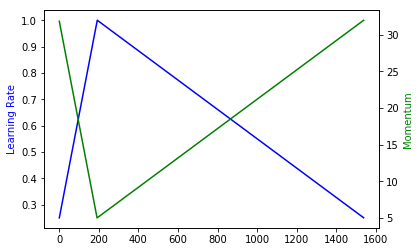

In [35]:
lr_scheduler.plot(len(data['train']) * 4)

In [ ]:
sess.train(schedule, 3)

In [ ]:
sess.save('ssd_2')

In [ ]:
sess.load('ssd_2')

In [ ]:
test(sess, anchors, data['valid'])

## More Anchors

In [ ]:
def var_from_np(arr, requires_grad=True):
    return Variable(torch.from_numpy(arr), requires_grad=requires_grad)

In [ ]:
anc_grids = [4,2,1]

anc_zooms = [1.]

anc_ratios = [(1.,1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]

# print(anchor_scales)

k = len(anchor_scales)

anc_offsets = [1/(o*2) for o in anc_grids]

k

In [ ]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag) for ao, ag in zip(anc_offsets, anc_grids)])

# print(anc_x)

anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag) for ao, ag in zip(anc_offsets, anc_grids)])

# print(anc_y)

anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

# print(anc_ctrs)

In [ ]:
anc_sizes = np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o, p in anchor_scales])
               for ag in anc_grids])

grid_sizes = var_from_np(np.concatenate([np.array([1/ag for i in range(ag*ag) for o, p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1).float()

anchors = var_from_np(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [ ]:
# anchors

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
show_ground_truth(ax, np.ones((3, 224, 224)), anchors.data.cpu().numpy() * 224)

In [ ]:
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(.4)
        self.sconv0 = StdConv(512,256, stride=1, drop_p=.4)
        self.sconv1 = StdConv(256,256, drop_p=.4)
        self.sconv2 = StdConv(256,256, drop_p=.4)
        self.sconv3 = StdConv(256,256, drop_p=.4)
        self.out0 = SSDOut(256, k)
        self.out1 = SSDOut(256, k)
        self.out2 = SSDOut(256, k)
        self.out3 = SSDOut(256, k)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

In [ ]:
model_ft = models.resnet18(pretrained=True)
layers = list(model_ft.children())[0:-2]
layers += [SSD_MultiHead(k, -4.)]
model = nn.Sequential(*list(layers))
# model

In [ ]:
class JaccardAccuracy(_AccuracyMeter):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.num_true_positives = 0
        self.num_false_positives = 0
        self.num_false_negatives = 0
        
    def update(self, output, label, log=False):
        pred_classes, bb_outputs = output
        for i, x in enumerate(label['CAT']): 
            if log: print("############ Next Example ###############")
                    
            pred_classes_i, bb_outputs_i = pred_classes[i], bb_outputs[i]   
              
            label_bbs, label_classes = format_label(label['BB'][i], label['CAT'][i])    
            label_bbs, label_classes = label_bbs.data.cpu(), label_classes.data.cpu()
            nms_classes, nms_conf, nms_bbs = make_output(pred_classes_i, bb_outputs_i)
            nms_classes, nms_conf, nms_bbs = nms_classes.cpu(), nms_conf.cpu(), torch_corners_to_center(nms_bbs.cpu())
            
            if log: print("Ground Truth Classes: ", label_classes); print("Ground Truth Bounding Boxes: ", label_bbs)
            
            if(len(nms_classes.size()) == 0): 
                if log: print("No Predictions")
                if log: print(f"Adding {label_classes.size()[0]} false negative(s)")
                self.num_false_negatives += label_classes.size()[0]
                continue   
            
            if log: print("Predicted Classes: ", nms_classes); print("Predicted Bounding Boxes: ", nms_bbs)
                
            pred_hits = torch.zeros(nms_classes.size()[0])
            label_hits = torch.zeros(len(label_classes))
                
            overlaps = jaccard(label_bbs, nms_bbs)
            
            for idx, cls, overlap in zip(range(len(label_classes)), label_classes, overlaps):              
                if log: print("------------ Next Label In Example -------------")
                if log: print("Ground Truth Class: ", cls); print("Overlaps For Class: ", overlap)
                
                matches = (overlap >= .5) * (nms_classes == cls)       
                
                if(matches.sum() > 0):
                    label_hits[idx] = 1
                                         
                if log: print("Predicted Bounding Boxes with the Correct Class Label and an Overlap >= .5: ", matches)
                    
                pred_hits[matches] = 1
            
            if log: print("------------ Results -------------")
                
            if log: print("Ground Truth Hits: ", label_hits)           
            if log: print("Prediction Hits: ", pred_hits) 
                
            self.num_true_positives += label_hits.sum()
            
            # self.num_correct_positives += pred_hits.sum()
            
            self.num_false_negatives += (label_hits != 1).sum()
            self.num_false_positives += (pred_hits != 1).sum()
            
            if log: print(f"{label_hits.sum()} true positives. {(pred_hits != 1).sum()} false positives. {(label_hits != 1).sum()} false negatives.")            
                                     
        
    def accuracy(self):
        precision = self.num_true_positives / (self.num_true_positives + self.num_false_positives)
        recall = self.num_true_positives / (self.num_true_positives + self.num_false_negatives) 
        return 2 * (precision * recall / (precision + recall))

In [ ]:
criterion = ssd_loss
optim_fn = optim.Adam
sess = Session(model, criterion, optim_fn, [*[1e-3] * 8, 1e-2])

In [ ]:
rawx,rawy,*_ = next(iter(data['valid']))
y = {key: Variable(util.to_gpu(value)) for key, value in rawy.items()}

In [ ]:
batch = sess.forward(rawx)

In [ ]:
accuracy = JaccardAccuracy()
accuracy.update(batch, y)

In [ ]:
test(sess, anchors, data['valid'])

In [ ]:
lr_find(sess, data['train'], start_lr=1e-7)

In [ ]:
sess.set_lr([*[8e-4 / 2] * 8, 8e-4])

In [ ]:
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
validator = Validator(data['valid'])
schedule = TrainingSchedule(data['train'], [lr_scheduler, validator])

In [ ]:
sess.train(schedule, 15)

In [ ]:
# sess.save("Resnet18Multi15")

In [ ]:
sess.load("Resnet18Multi15")

In [ ]:
test(sess, anchors, data['valid'])

In [ ]:
sess.train(schedule, 15)

In [ ]:
sess.save("Resnet34Multi2")

In [ ]:
sess.load("Resnet34Multi2")

In [ ]:
test(sess, anchors, data['valid'])

## Inference Test Data

In [ ]:
def inference_test_data():
    inferences = []

    prints = 0

    with EvalModel(sess.model):
        for x,y,meta in data['test']:
            pred_classes, bb_outputs = sess.forward(x)
            for idx, file in enumerate(meta['file']):
                nms_classes, nms_conf, nms_bbs = make_output(pred_classes[idx], bb_outputs[idx])

                if prints < 16 and random.random() <= .01:
                    fig, ax = plt.subplots(figsize=(12,12))
                    ax.set_title(file.split("\\")[-1])
                    im = denorm(x[idx]).numpy()
                    nms_bbs_as_numpy = torch_corners_to_center(nms_bbs.cpu()).numpy()
                    torch_gt(ax, im, nms_bbs_as_numpy, nms_classes.cpu().numpy(), nms_conf.cpu().numpy())
                    prints += 1

                nms_classes, nms_conf, nms_bbs = nms_classes.cpu().numpy(), nms_conf.cpu().numpy(), nms_bbs.cpu().numpy()   

                preds = []

                for idx, cls, bb in zip(range(5), nms_classes, nms_bbs):
                    corners = (bb * 600).clip(0,600).astype(int)
                    assert(corners[0] < corners[2] and corners[1] < corners[3])
                    preds.append(f'{cls} {" ".join(corners.astype(str))}')

                inferences.append({'filename': file.split("\\")[-1], 'prediction': " ".join(preds)})

    df = pd.DataFrame(inferences, columns=['filename', 'prediction'])
    df.to_csv(f'Submissions/submission.{time.strftime("%Y%m%d-%H%M%S")}.csv', header=False, index=False)

In [ ]:
inference_test_data()